In [13]:
import pandas as pd
import seaborn as sns
import tensorflow
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50,VGG16,VGG19
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG, load_img
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D,BatchNormalization,GlobalAveragePooling2D,MaxPooling2D,concatenate, Conv2DTranspose,Conv2D
from tensorflow.keras.models import load_model
from PIL import Image,ImageFilter
import numpy as np
import matplotlib.image as img 
import matplotlib.pyplot as plt

In [2]:
img_size=224
img_size_dim=[224,224]
dimension=(img_size,img_size)
zoom=[0.99,1.01]
bright=[0.8,1.2]
fill_mode='constant'
data_format='channels_last'
dir=r'D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
data_gen=IDG(rescale=1./255,brightness_range=bright,zoom_range=zoom,data_format=data_format,fill_mode=fill_mode,horizontal_flip=True)
train_data_gen=data_gen.flow_from_directory(directory=dir,target_size=dimension,batch_size=12446,shuffle=False)

Found 12446 images belonging to 4 classes.


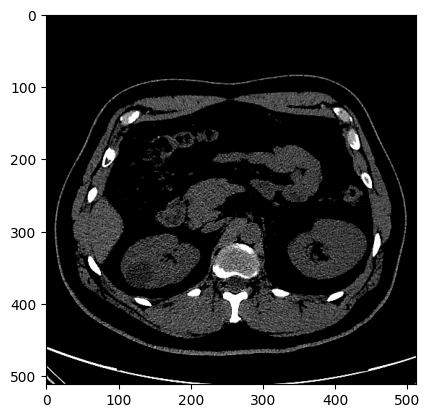

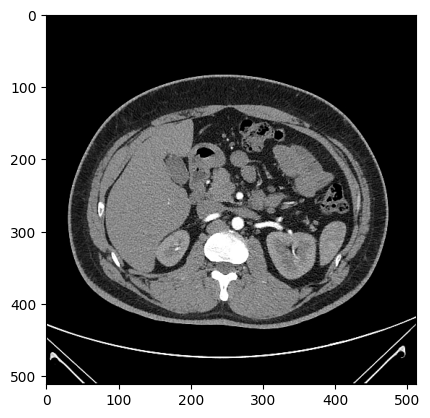

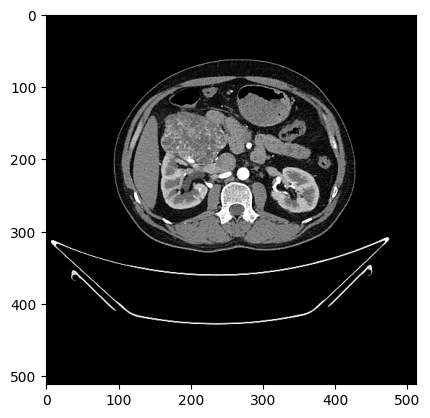

In [16]:
img1= Image.open(r"D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Cyst\Cyst- (11).jpg")
image_sharp=img1.filter(ImageFilter.SHARPEN)
plt.imshow(image_sharp)
plt.show()
img2=Image.open(r"D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Normal\Normal- (26).jpg")
image_sharp=img2.filter(ImageFilter.SHARPEN)
plt.imshow(image_sharp)
plt.show()
img3=Image.open(r"D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Tumor\Tumor- (26).jpg")
image_sharp=img3.filter(ImageFilter.SHARPEN)
plt.imshow(image_sharp)
plt.show()

In [3]:
train_data_gen

In [4]:
train_data_all,train_labels_all=train_data_gen.next()
print(train_data_all.shape,train_labels_all.shape)

(12446, 224, 224, 3) (12446, 4)


In [5]:
train_labels_all.shape

(12446, 4)

In [13]:
c=0
d=0
e=0
f=0
for i in train_labels_all:
    if i[0] == 1:
        c=c+1
    if i[1] == 1:
        d=d+1
    if i[2] == 1:
        e=e+1
    if i[3] == 1:
        f=f+1
print(c)
print(d)
print(e)
print(f)
print(c+d+e+f)

3709
5077
1377
2283
12446


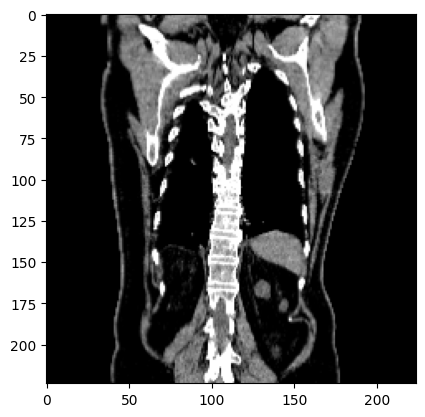

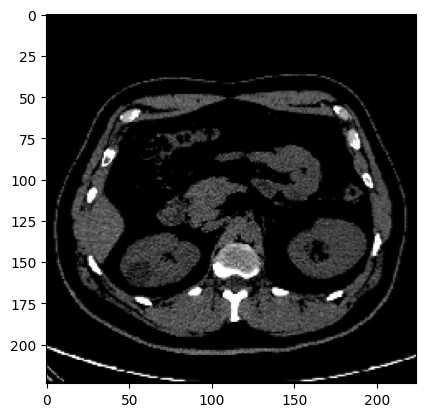

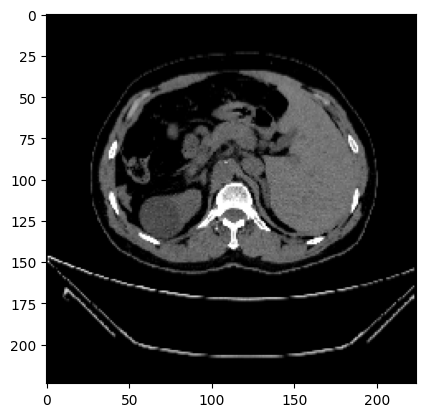

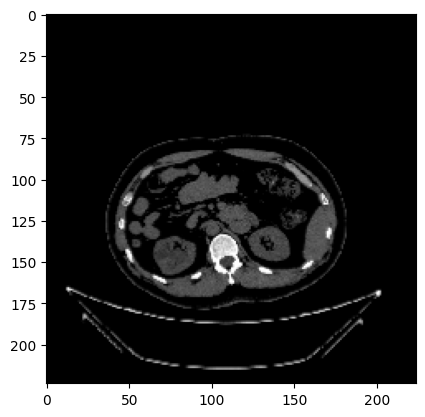

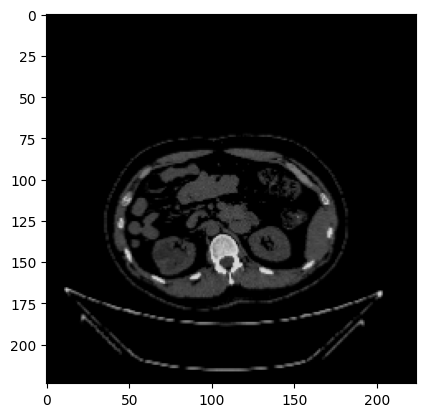

In [7]:
for i in range(5):
    plt.imshow(train_data_all[i])
    plt.show()

In [4]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels = train_test_split(train_data_all,train_labels_all,test_size=0.2,random_state=47)
train_data,val_data,train_labels,val_labels = train_test_split(train_data_all,train_labels_all,test_size=0.2,random_state=47)

In [5]:
early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True) 

In [ ]:
pretrained_model= keras.applications.VGG19(include_top=False,input_shape=(224,224,3),pooling='max',classes=4,weights='imagenet')
pretrained_model.trainable=False
x=pretrained_model.output
x=Flatten()(x)
x=Dense(512,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(4,activation='softmax')(x)
model=Model(inputs=pretrained_model.input,outputs=x)
model.summary()

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss=keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])
model.fit(train_data,train_labels,epochs=10,
                 validation_data=(val_data,val_labels))

In [ ]:
img=image.load_img(r"D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Normal\Normal- (29).jpg")
img=img.resize((224,224))

In [ ]:
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)

In [ ]:
print(np.argmax(model.predict(x),axis=1)[0])

In [ ]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
        
    def generate(self, image_array, class_idx):
        with tf.GradientTape() as tape:
            conv_outputs, predictions = self.grad_model(image_array)
            loss = predictions[:, class_idx]

        output = conv_outputs[0]
        grads = tape.gradient(loss, conv_outputs)[0]

        guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

        weights = tf.reduce_mean(guided_grads, axis=(0, 1))

        cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (image_array.shape[2], image_array.shape[1]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [ ]:


# Load and preprocess image
img_path = "D:/Datasets/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (4).jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Initialize GradCAM
gradcam = GradCAM(test, 'block5_conv1')

# Generate GradCAM heatmap
class_idx = 0  # Specify the class index (0-999 for ImageNet)
heatmap = gradcam.generate(x, class_idx)

# Superimpose heatmap on the original image
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + cv2.cvtColor(x[0], cv2.COLOR_RGB2BGR)
plt.imshow(superimposed_img, cmap="jet")
plt.show()
cv2.imwrite('D:/Datasets/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/gradcam_cyst.jpg', superimposed_img)


In [ ]:
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy
    return tf.nn.relu(x), grad

In [ ]:
for layer in test.layers:
    if isinstance(layer, tf.keras.layers.ReLU):
        layer.activation = guided_relu

In [ ]:
def get_gradcam(input_model, image, layer_name):
    grad_model = tf.keras.models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    guided_grads = conv_output * pooled_grads[..., tf.newaxis]
    return guided_grads, class_idx

def guided_grad_cam(input_model, image, layer_name):
    guided_grads, class_idx = get_gradcam(input_model, image, layer_name)
    cam = tf.reduce_sum(guided_grads, axis=-1)
    return cam, class_idx

In [ ]:
img = image.load_img(r"D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Tumor\Tumor- (334).jpg")  # Load your example image here
img=img.resize((224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)


In [ ]:
cam, class_idx = guided_grad_cam(test, x, "block2_conv2")
print(class_idx)
# Visualize the Guided Grad-CAM
plt.imshow(cam, cmap="jet")
plt.show()
#plt.savefig('D:/Datasets/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/guided_gradcam_cyst_2.jpg')

In [ ]:
def smoothgrad(input_model, image, n=50, stdev=0.1):
    smoothgrads = []
    for _ in range(n):
        noise = np.random.normal(0, stdev, image.shape)
        noisy_image = image + noise
        gradients = tf.GradientTape(input_model.output, input_model.input, noisy_image)
        smoothgrads.append(gradients)
    smoothgrads = np.mean(smoothgrads, axis=0)
    return smoothgrads


In [ ]:
img = image.load_img(r"D:\Datasets\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone\Tumor\Tumor- (334).jpg")  # Load your example image here
img=img.resize((224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
def create_occlusion_map(model, image, patch_size, stride):
    occlusion_map = np.zeros((image.shape[1], image.shape[2]))

    for i in range(0, image.shape[1] - patch_size, stride):
        for j in range(0, image.shape[2] - patch_size, stride):
            input_image = image.copy()
            input_image[:, i:i+patch_size, j:j+patch_size, :] = 0  # Occlude the patch

            prediction = model.predict(input_image)
            prob = tf.nn.softmax(prediction, axis=-1)
            top_prob = np.max(prob[0])

            occlusion_map[i:i+patch_size, j:j+patch_size] = top_prob

    return occlusion_map


In [ ]:
patch_size = 60  # Size of the occlusion patch
stride = 20  # Stride for the occlusion patch
occlusion_map = create_occlusion_map(test, x, patch_size, stride)

In [ ]:
plt.imshow(occlusion_map, cmap='jet', alpha=0.5)
plt.imshow(img, alpha=0.5)
plt.axis('off')
plt.show()

In [ ]:
vgg16=tf.keras.models.load_model("D:/Project/DL_project/vgg.keras")
vgg16.summary()

In [ ]:
print(test.history.history)